In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as plot
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from fbprophet import Prophet

## 1. Import Raw Data

In [2]:
#Import vaccinnation data https://www.kaggle.com/gpreda/covid-world-vaccination-progress
vaccinations_df = pd.read_csv('./Raw-data/country_vaccinations_raw.csv')
#Import infections and death data https://www.kaggle.com/josephassaker/covid19-global-dataset
daily_data_df = pd.read_csv('./Raw-data/worldometer_coronavirus_daily_data_raw.csv')

In [3]:
vaccinations_df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...


## 2. Clean Raw Data

In [4]:
#Drop Columns not needed
cleaned_vaccinations_df = vaccinations_df.drop(["iso_code", 'daily_vaccinations_raw', "source_name", "source_website", "daily_vaccinations_per_million", "people_fully_vaccinated_per_hundred", "people_vaccinated_per_hundred", "total_vaccinations_per_hundred"], axis=1)

In [5]:
cleaned_vaccinations_df['date'] = pd.to_datetime(cleaned_vaccinations_df["date"])
cleaned_vaccinations_df.head()

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,vaccines
0,Albania,2021-01-10,0.0,0.0,NaN,NaN,Pfizer/BioNTech
1,Albania,2021-01-11,NaN,NaN,NaN,64.0,Pfizer/BioNTech
2,Albania,2021-01-12,128.0,128.0,NaN,64.0,Pfizer/BioNTech
3,Albania,2021-01-13,188.0,188.0,NaN,63.0,Pfizer/BioNTech
4,Albania,2021-01-14,266.0,266.0,NaN,66.0,Pfizer/BioNTech


In [6]:
#Clean second DF - Daily_data
cleaned_daily_data_df = daily_data_df[daily_data_df["date"] > "2021-1-01"]
cleaned_daily_data_df['country'] = cleaned_daily_data_df['country'].replace("USA", "United States")
cleaned_daily_data_df['country'] = cleaned_daily_data_df['country'].replace("UK", "United Kingdom")
cleaned_daily_data_df['date'] = pd.to_datetime(cleaned_daily_data_df["date"])
#cleaned_daily_data_df['country'].unique()

/Users/roseabdallah/opt/anaconda3/envs/PythonTime/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/roseabdallah/opt/anaconda3/envs/PythonTime/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/roseabdallah/opt/anaconda3/envs/PythonTime/lib/python3.7/site-packages/ipykernel_launcher

In [7]:
#Merge two dataframes into one df
combined_df = pd.merge(cleaned_vaccinations_df, cleaned_daily_data_df, how='inner', on=("country", 'date'))
combined_df.head()

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,vaccines,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,Albania,2021-01-10,0.0,0.0,NaN,NaN,Pfizer/BioNTech,63595.0,562.0,24706.0,1241.0,8.0
1,Albania,2021-01-11,NaN,NaN,NaN,64.0,Pfizer/BioNTech,63971.0,376.0,24743.0,1247.0,6.0
2,Albania,2021-01-12,128.0,128.0,NaN,64.0,Pfizer/BioNTech,64627.0,656.0,24954.0,1252.0,5.0
3,Albania,2021-01-13,188.0,188.0,NaN,63.0,Pfizer/BioNTech,65334.0,707.0,25218.0,1256.0,4.0
4,Albania,2021-01-14,266.0,266.0,NaN,66.0,Pfizer/BioNTech,65994.0,660.0,25487.0,1261.0,5.0


In [8]:
# Drop the null columns where all values are null
cleaned_combined_data_df = combined_df.dropna(axis='columns', how='all')
# Drop the null rows
cleaned_combined_data_df = cleaned_combined_data_df.dropna()
#cleaned_combined_data_df["country"].value_counts()

In [9]:
#Sort DF based on number of people fully vaccinated
total_by_country=cleaned_combined_data_df.groupby(["country"])["people_fully_vaccinated"].max().sort_values(ascending=False)

In [10]:
#Select countries (top 10) that will part of analysis
#Top 10 countries that started vaccinating early on and have the most data

countries = ["United States", "Israel", "Germany","Italy","United Kingdom","Romania","Mexico", "Chile", "Denmark", "Belgium"]
#countries

In [11]:
#Build DF from clean_data and filter using the top 10 countries defined above
final_df = cleaned_combined_data_df[cleaned_combined_data_df['country'].isin(countries)]
final_df['country'].value_counts()
final_df

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,vaccines,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
496,Belgium,2021-01-18,134885.0,134776.0,109.0,14593.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",678839.0,1630.0,611445.0,20435.0,39.0
497,Belgium,2021-01-19,154096.0,153806.0,290.0,15119.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",679771.0,932.0,611973.0,20472.0,37.0
498,Belgium,2021-01-20,175158.0,174445.0,713.0,15115.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",681250.0,1479.0,613181.0,20554.0,82.0
499,Belgium,2021-01-21,204964.0,204251.0,713.0,16085.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",684256.0,3006.0,616169.0,20572.0,18.0
500,Belgium,2021-01-22,234223.0,233479.0,744.0,16963.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",686827.0,2571.0,618532.0,20620.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4298,United States,2021-03-01,76899987.0,50732997.0,25466405.0,1817502.0,"Moderna, Pfizer/BioNTech",29332997.0,55181.0,8999111.0,527250.0,1484.0
4299,United States,2021-03-02,78631601.0,51755447.0,26162122.0,1942788.0,"Moderna, Pfizer/BioNTech",29390540.0,57543.0,8959657.0,529341.0,2091.0
4300,United States,2021-03-03,80540474.0,52855579.0,26957804.0,2010790.0,"Moderna, Pfizer/BioNTech",29457765.0,67225.0,8922653.0,531719.0,2378.0
4301,United States,2021-03-04,82572848.0,54035670.0,27795980.0,2042676.0,"Moderna, Pfizer/BioNTech",29526423.0,68658.0,8898751.0,533768.0,2049.0


### 2.a Save final DF to CSV

In [12]:
#Save final dataframe to CSV
final_df.to_csv("./CovidApp/static/data/Final_Clean_Data.csv")


## 3.Convert TimeSeries Data to CommonDate Data

In [13]:
#Use Israel first day of vaccines as day zero. Israel is the country that started reporting vaccines before any other country.
df_Israel = final_df[final_df['country']=='Israel']
df_Israel.head()

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,vaccines,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
2114,Israel,2021-01-04,1446357.0,1446355.0,2.0,131444.0,"Moderna, Pfizer/BioNTech",448173.0,9304.0,53912.0,3445.0,29.0
2115,Israel,2021-01-05,1573123.0,1573121.0,2.0,127069.0,"Moderna, Pfizer/BioNTech",456139.0,7966.0,58933.0,3495.0,50.0
2116,Israel,2021-01-06,1677956.0,1677954.0,2.0,120001.0,"Moderna, Pfizer/BioNTech",463448.0,7309.0,61553.0,3527.0,32.0
2117,Israel,2021-01-07,1795426.0,1795421.0,5.0,113975.0,"Moderna, Pfizer/BioNTech",471048.0,7600.0,64583.0,3552.0,25.0
2118,Israel,2021-01-08,1862573.0,1862565.0,8.0,113260.0,"Moderna, Pfizer/BioNTech",477357.0,6309.0,65008.0,3596.0,44.0


In [14]:
#Loop through country list to find date ranges for each country
#Start counting day zero as the day where there were more than "filter_vac" number.

# Initialize day count
days_country={}
filter_vac=2
for country in final_df['country'].unique():
    #print(country)
    days_country[country]=list(final_df['daily_vaccinations'][(final_df['country']==country) & (final_df['people_fully_vaccinated']>filter_vac)].values)

In [15]:
#Find Max number of days for each country in DF
n_max=0
for k,v in days_country.items():
    #print(f"{k} has {len(v)}")
    if len(v) > n_max:
        n_max=len(v)
#print(n_max)

In [16]:
#Add leading zeros to countries that reported zero vaccines at the beginning of January.
for k,v in days_country.items():
    #print(f"{k} has {len(v)}")
    if len(v) < n_max:
        for i in range(0,n_max-len(v)):
            days_country[k].insert(0,0)
#ays_country

In [17]:
#Create new data frame with common date for all top 10 countries
#Create days_dimension
days_dimension=pd.DataFrame(days_country)
#Save DF as a CSV
#days_dimension.to_csv("./Resources/days_dimension.csv")

## 4. Analysis

Text(0.5, 1.0, 'All Countries: Pct Change in Vaccination Rate per Day')

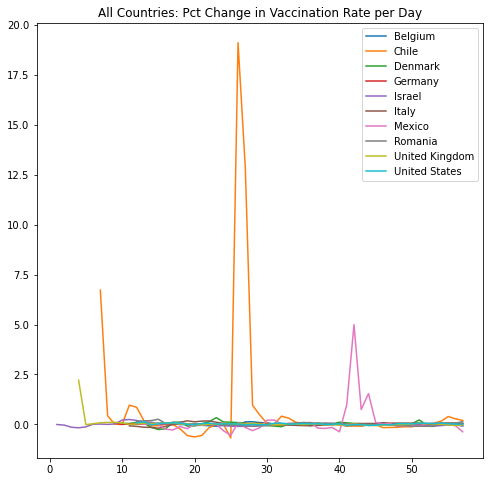

In [18]:
# Plot Percentage change by country
fig1=days_dimension.pct_change().plot(figsize = (8,8))
plt.title('All Countries: Pct Change in Vaccination Rate per Day')
#plt.savefig("./Images/pct-change.png");

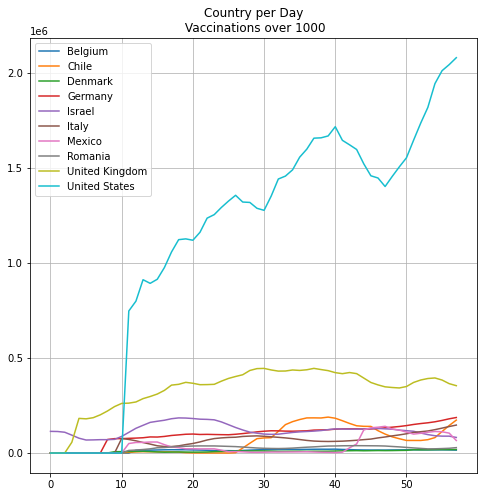

In [19]:
#Plot vaccinations by country 
days_dimension.iloc[:,:].plot(figsize = (8,8))
plt.grid(b=True,alpha=20.0)
plt.title('Country per Day\n Vaccinations over 1000')
plt.savefig("./CovidApp/static/images/allcountries");

In [20]:
#View date for Israel
#final_df[['date','daily_vaccinations']][(final_df['country']=='Israel') & (final_df['people_fully_vaccinated']>1000)]

In [21]:
#View date for US
#final_df[['date','daily_vaccinations']][(final_df['country']=='United States') & (final_df['people_fully_vaccinated']>200)]

## 5. Machine Learning Models

In [22]:
# Use day_dimension for all models
days_dimension.head(100)

,Belgium,Chile,Denmark,Germany,Israel,Italy,Mexico,Romania,United Kingdom,United States
0,0.0,0.0,0.0,0.0,113975.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,113260.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,109343.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,94069.0,0.0,0.0,0.0,56766.0,0.0
4,0.0,0.0,0.0,0.0,78002.0,0.0,0.0,0.0,182220.0,0.0
5,0.0,0.0,0.0,0.0,68452.0,0.0,0.0,0.0,179880.0,0.0
6,0.0,147.0,0.0,0.0,69102.0,0.0,0.0,0.0,185810.0,0.0
7,0.0,1135.0,0.0,0.0,70280.0,0.0,0.0,0.0,201020.0,0.0
8,0.0,1625.0,0.0,71090.0,70278.0,0.0,0.0,0.0,220981.0,0.0
9,0.0,1638.0,7093.0,75704.0,71833.0,0.0,0.0,0.0,244311.0,0.0


In [23]:
# Trained model via model.fit
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [24]:
#Function "Model_Performace" to build regression line (test and prediction) using the correct starting day
def model_performance(y_test,y_pred,starting_point):
    index=range(starting_point,starting_point+days_split)
    df_eval=pd.DataFrame({'y_test':y_test.ravel(),'y_pred':y_pred},index=index)
    df_eval['error']=df_eval['y_test']-df_eval['y_pred']
    df_eval['error_rate']=round(df_eval['error']/df_eval['y_test'],2)
    return df_eval

In [25]:
#top 10 countries used in loop
countries = days_dimension.columns.tolist()

###     5.1. Linear Regresion: Univariate 
####     Focus on determining relationship between one independent (explanatory variable) variable and one dependent variable
####     X = (input of index) 
####     y = vaccines per day for a given country

In [26]:
#Check how many records for days in days_dimesion DF
len(days_dimension)

# Total number of days to use
total_days = len(days_dimension)
print("Total number of days "+ str(total_days))

# Finding 80% of days to use for training Data 
print("80% of days "+str(len(days_dimension)*.8))

# Finding 20% of days to use for test Data 
print("20% of days "+str(len(days_dimension)*.2))

Total number of days 58
80% of days 46.400000000000006
20% of days 11.600000000000001


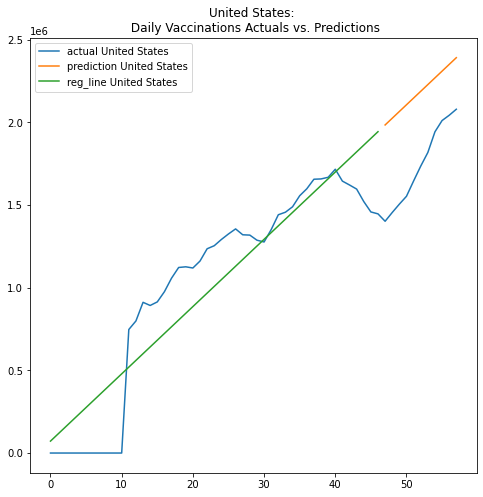

In [27]:
# Model vs. Actual

#Save plots for every country as image
for country in countries:
    #print(country)
    
    #Calculate X and y
    X=np.array(list(days_dimension.index)).reshape(-1,1)
    y=days_dimension[country]
    
    #Calculate Trainig and Test Split
    days_split=11
    X_train,X_test,y_train,y_test=X[0:-days_split],X[-days_split:],y[0:-days_split],y[-days_split:]

    # X_test,X_train
    starting_point=len(X_train)
    len(X_train),len(y_test)
    
    #Fit the Model
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    eval_country3=model_performance(y_test,y_pred,starting_point)
    #eval_country3.head()

    Y_mx_b3=model.predict(X_train)
    Y_mx_b3=pd.DataFrame({'reg_line '+country:Y_mx_b3})
    
    plt.clf() #clear graph for every country to come up with one graph per country
    ax=days_dimension[country].plot(figsize = (8,8),label=f'actual {country}')
    eval_country3['y_pred'].plot(ax=ax, label=f'prediction {country}')
    Y_mx_b3.plot(ax=ax)
    plt.legend(loc='best')
    plt.title(f"{country}: \n Daily Vaccinations Actuals vs. Predictions")
    plt.savefig(f"./CovidApp/static/images/{country}-ML-daily-vac.png");   

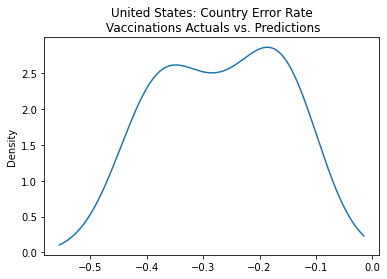

In [28]:
# Error Plots

#Save plots for every country as image
for country in countries:
    
    plt.clf() #clear graph for every country to come up with one graph per country
    eval_country3['error_rate'].plot(kind='kde')
    plt.title(f"{country}: Country Error Rate\n Vaccinations Actuals vs. Predictions")
    #plt.savefig(f"./Images/{country}-error_rate.png");

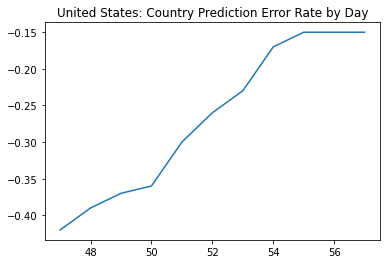

In [29]:
# Error Plots by prediction day

#Save plots for every country as image
for country in countries:
    
    plt.clf() #clear graph for every country to come up with one graph per country
    eval_country3['error_rate'].plot()
    plt.title(f"{country}: Country Prediction Error Rate by Day")
    #plt.savefig(f"./Images/{country}-error_rate_pred_day.png");


In [30]:
for c in days_dimension.columns[0:]:
    if days_dimension[c].std() >100000.0:
        #print("Larger Pops")
        print(f"{c} -> Std Deviation: {days_dimension[c].std():,.2f} Median: {days_dimension[c].median():,.2f}")
    elif (days_dimension[c].std() >30000.0) & (days_dimension[c].std() <100000.0):
        #print("Medium Pops")
        print(f"{c} -> Std Deviation: {days_dimension[c].std():,.2f} Median: {days_dimension[c].median():,.2f}")
    else:
        #print("Other")
        print(f"{c} -> Std Deviation: {days_dimension[c].std():,.2f} Median: {days_dimension[c].median():,.2f}")

Belgium -> Std Deviation: 7,041.19 Median: 16,147.00
Chile -> Std Deviation: 69,457.01 Median: 58,714.00
Denmark -> Std Deviation: 5,204.31 Median: 9,345.00
Germany -> Std Deviation: 47,892.30 Median: 108,923.50
Israel -> Std Deviation: 32,358.18 Median: 116,439.50
Italy -> Std Deviation: 37,801.09 Median: 69,520.00
Mexico -> Std Deviation: 46,507.92 Median: 18,434.50
Romania -> Std Deviation: 13,413.00 Median: 28,390.50
United Kingdom -> Std Deviation: 113,853.61 Median: 365,861.50
United States -> Std Deviation: 629,004.34 Median: 1,322,465.00


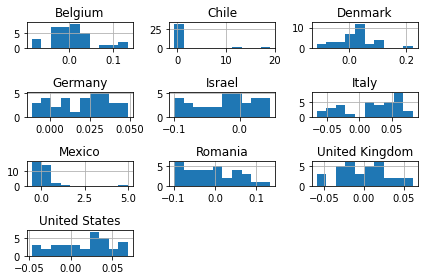

In [31]:
days_dimension.pct_change().dropna()[12:].hist()
plt.tight_layout()

###     5.2. Linear Regresion: Multivariante 
####      Estimates a single regression model with more than one variable

####     Israel is used as X because it is the first country that started vaccinations early on
####     X = (input of index) AND (vaccines per day of Israel)
####     y = vaccines per day for a given country

In [32]:
# Multivariant code
#Define X
X_mv=pd.DataFrame(
    {'days':np.array(list(days_dimension.index)),
    'israel':days_dimension['Israel'].values
    })

X_mv.head()

#Define Y
country_mv = "United Kingdom" #can use country as a variable
y_mv=days_dimension[country_mv]

print("X: Israel"+" Y: "+country_mv)
X_mv.head()

X: Israel Y: United Kingdom


,days,israel
0,0,113975.0
1,1,113260.0
2,2,109343.0
3,3,94069.0
4,4,78002.0


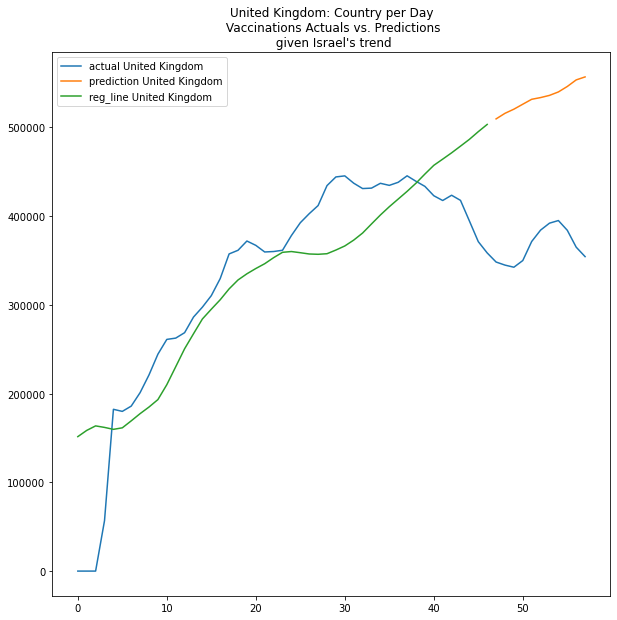

In [33]:
#Calculate Trainig and Test Split
#10 days is the equivalent of 20% Testing
X_train,X_test,y_train,y_test=X_mv[0:-days_split],X_mv[-days_split:],y_mv[0:-days_split],y_mv[-days_split:]

# X_test,X_train
starting_point=len(X_train)
len(X_train),len(y_test)

#Fit the Model
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

eval_country_mv=model_performance(y_test,y_pred,starting_point)
#eval_country_mv.head()

Y_mx_b_4=model.predict(X_train)
Y_mx_b_4=pd.DataFrame({'reg_line '+country_mv:Y_mx_b_4})

plt.clf() #clear graph for every country to come up with one graph per country
ax=days_dimension[country_mv].plot(figsize = (10,10),label=f'actual {country_mv}')
eval_country_mv['y_pred'].plot(ax=ax,label=f'prediction {country_mv}')
Y_mx_b_4.plot(ax=ax,label='regressed line')
plt.legend(loc='best')
plt.title(f"{country_mv}: Country per Day\n Vaccinations Actuals vs. Predictions\n given Israel's trend")
plt.savefig(f"./Images/{country_mv}-multivariante.png");

###     5.3. TimeSeries: FB Prophet
####      Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

####     Using DF to forecast given variable 30 days out.
####     X = days
####     y = variable to forecast (ex. people fully vaccianted)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

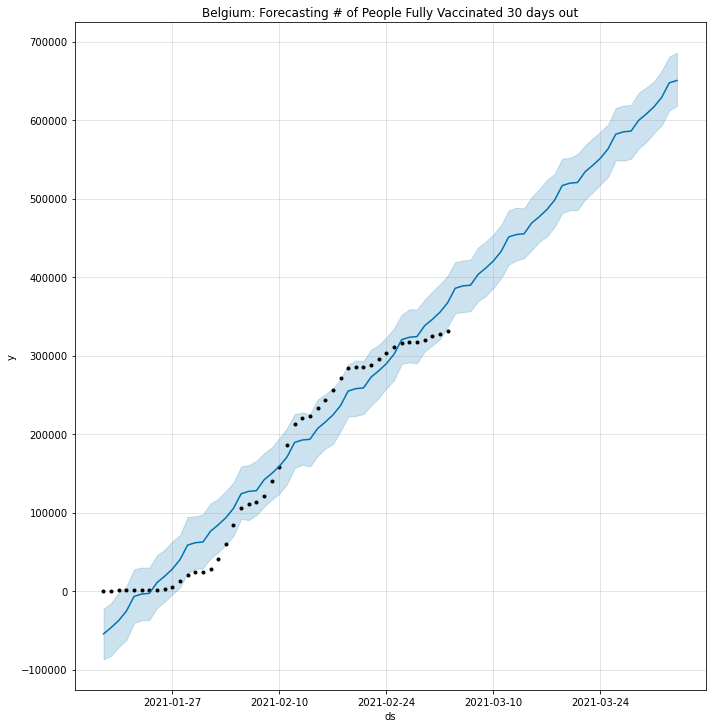

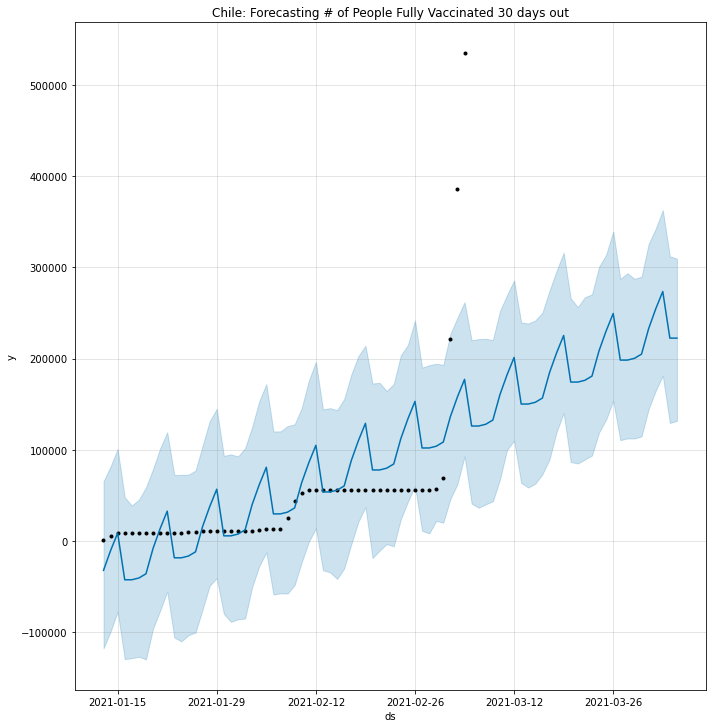

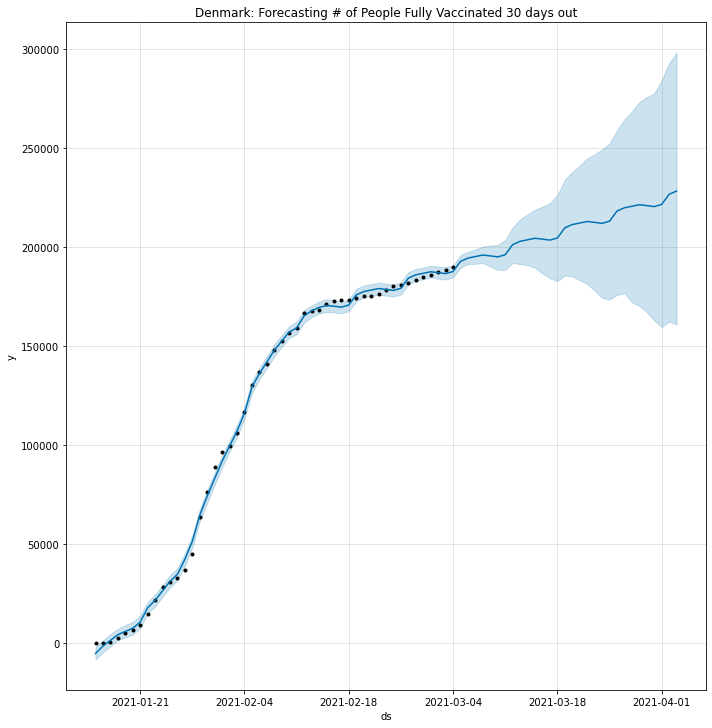

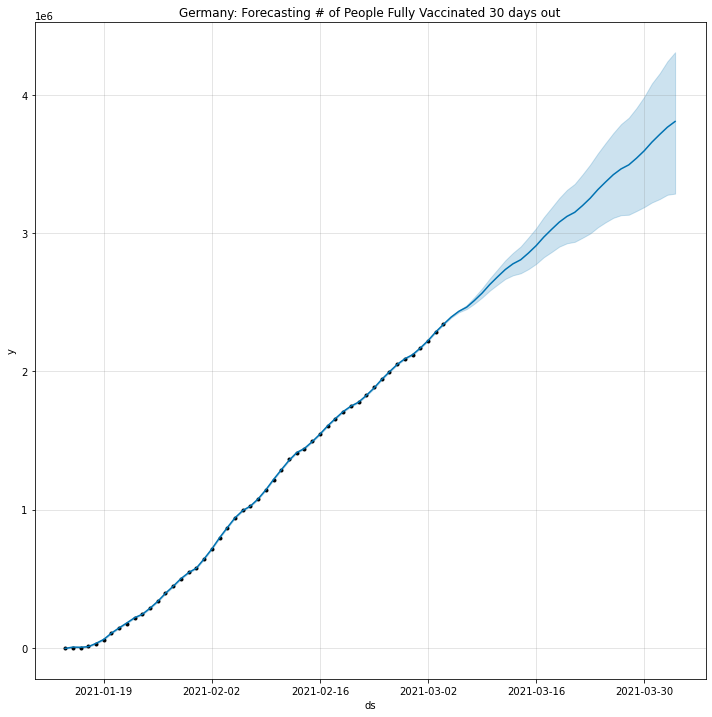

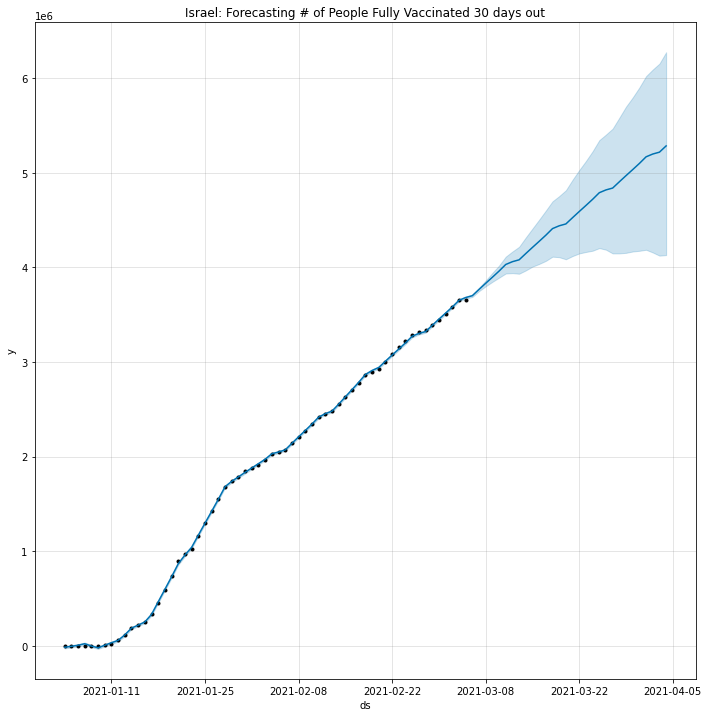

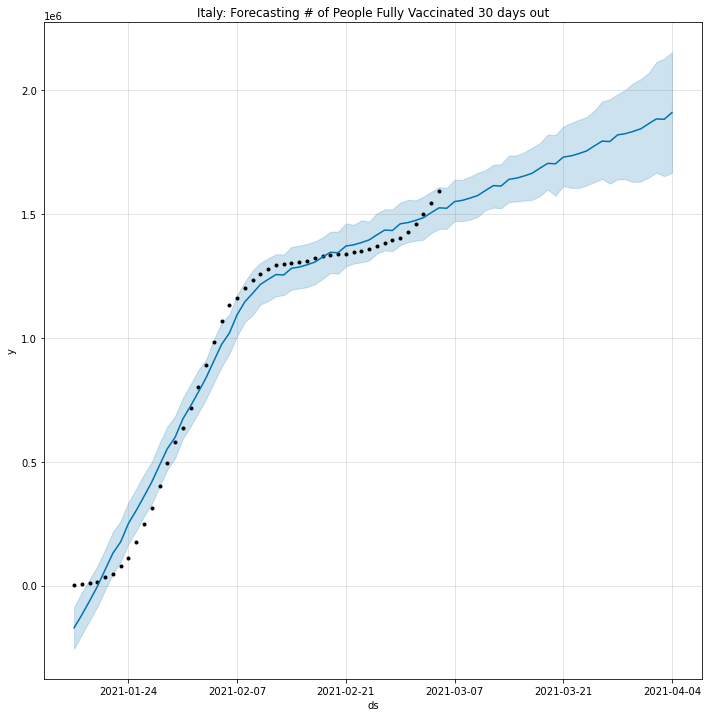

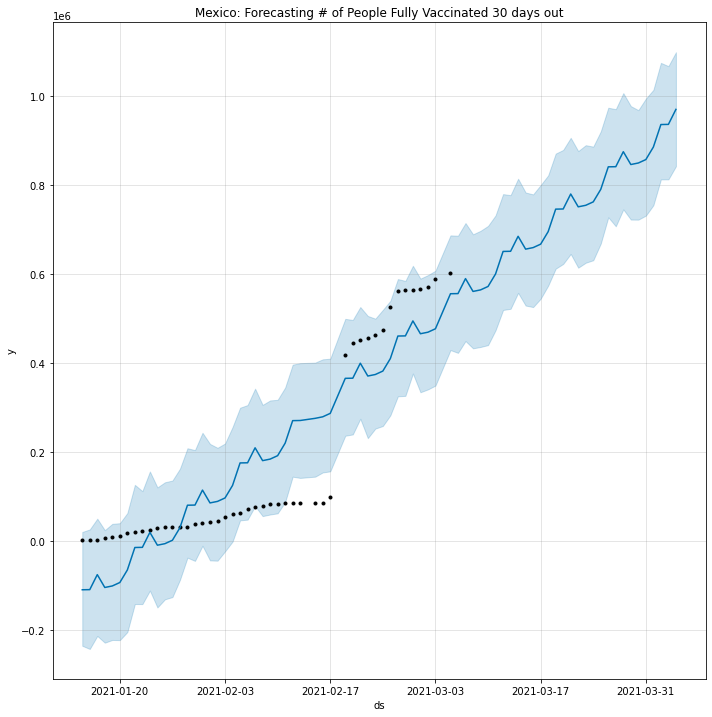

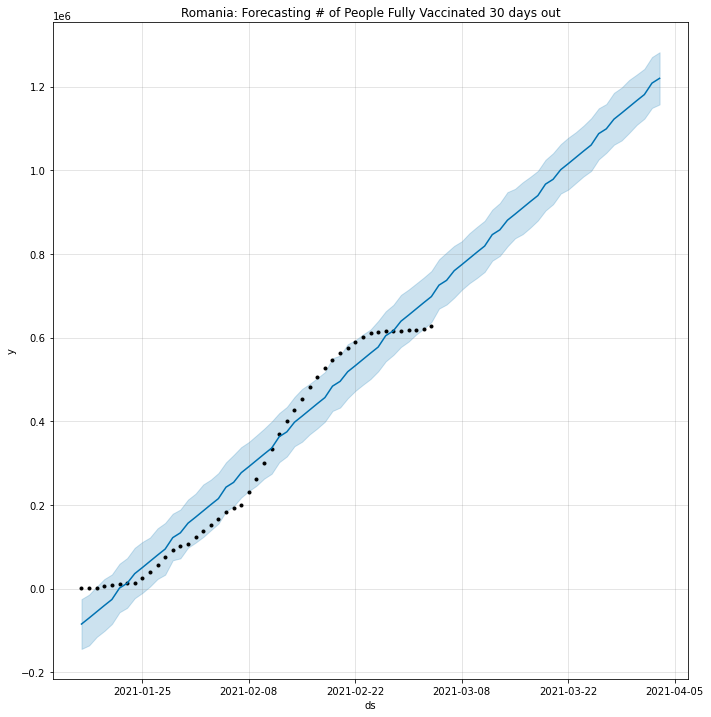

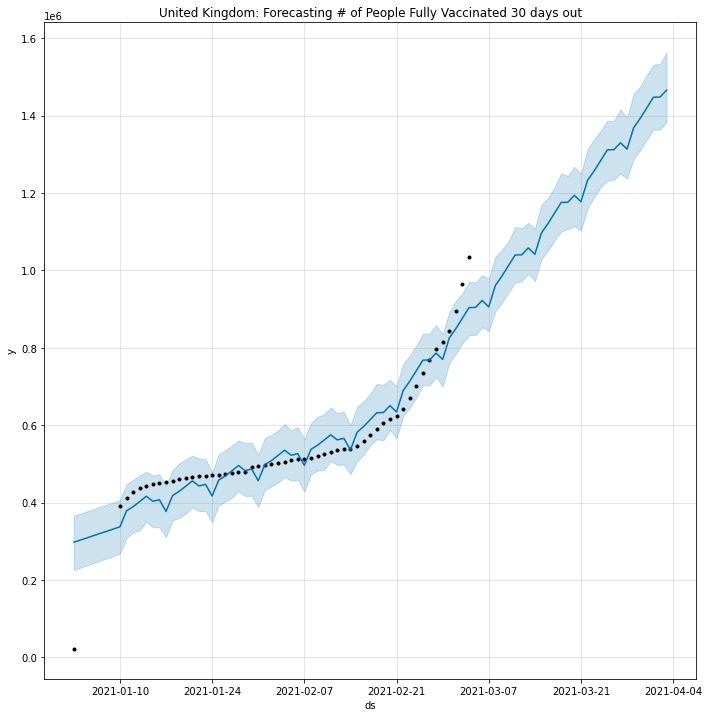

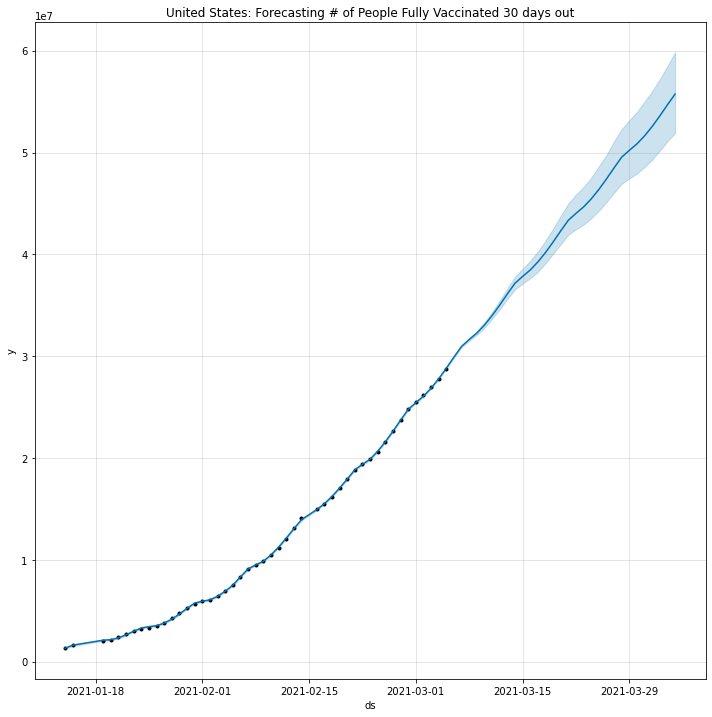

In [34]:
for country in countries:
    country_df=final_df.loc[final_df['country']==country].rename(columns={'date':'ds','people_fully_vaccinated':'y'})
    fb_model=Prophet()
    fb_model.fit(country_df)
    fb_data_future=fb_model.make_future_dataframe(periods=30)
    fb_forecast=fb_model.predict(fb_data_future)
    #fb_forecast[['trend','yhat']].plot()
    fig,ax=plt.subplots(figsize=(10,10))
    fig_fb=fb_model.plot(fb_forecast,ax=ax)
    ax.set_title(f"{country}: Forecasting # of People Fully Vaccinated 30 days out")
    plt.savefig(f"./CovidApp/static/images/{country}-fully-vac.png");

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

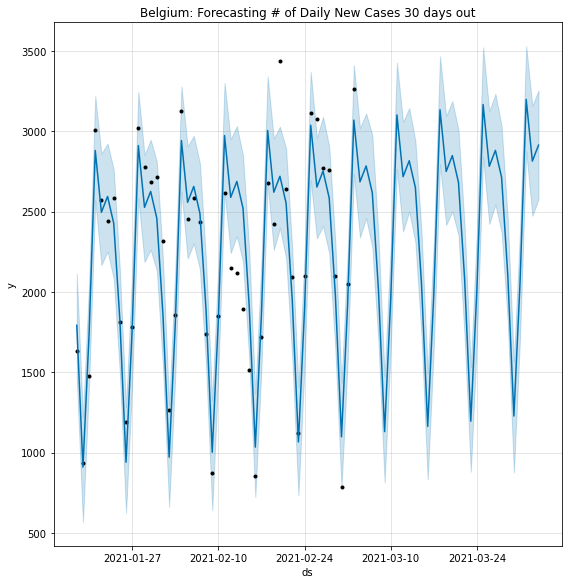

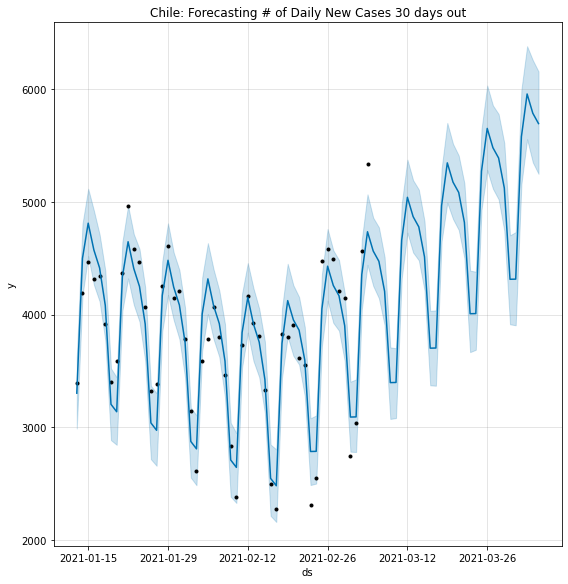

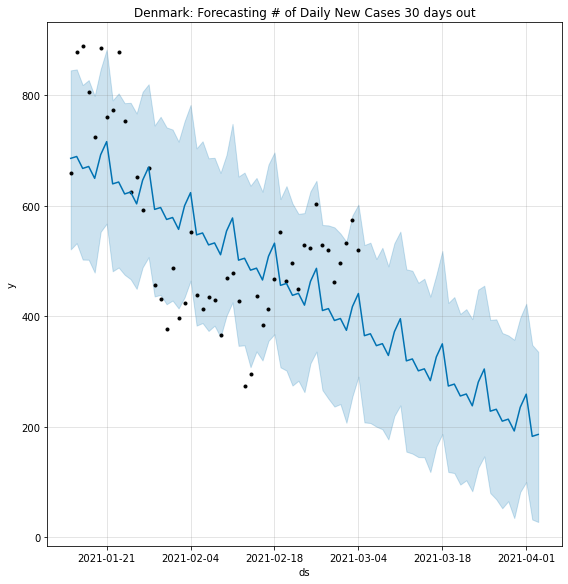

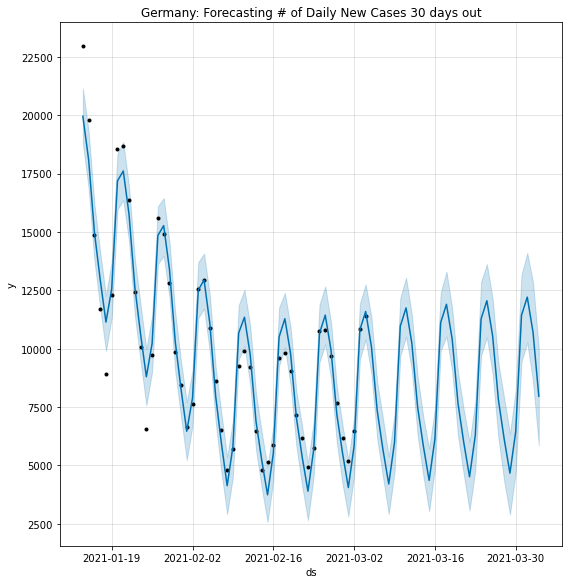

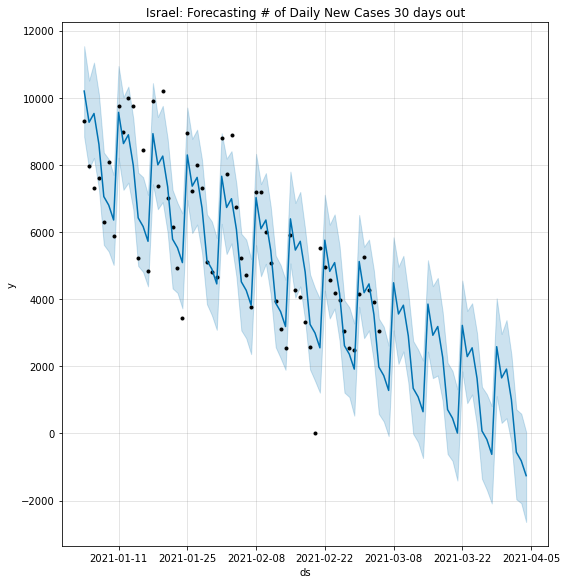

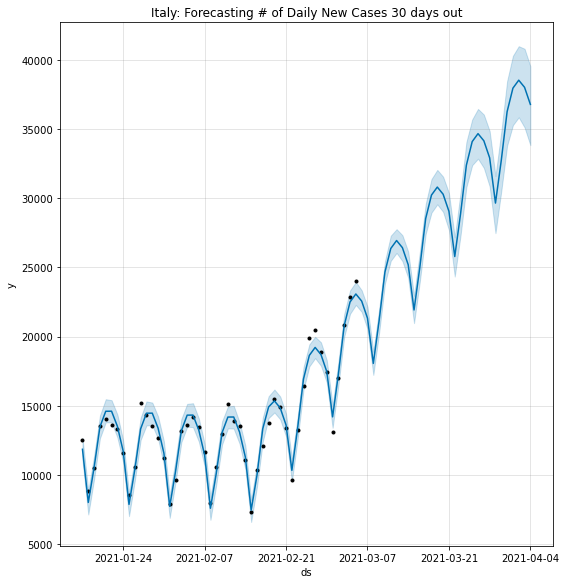

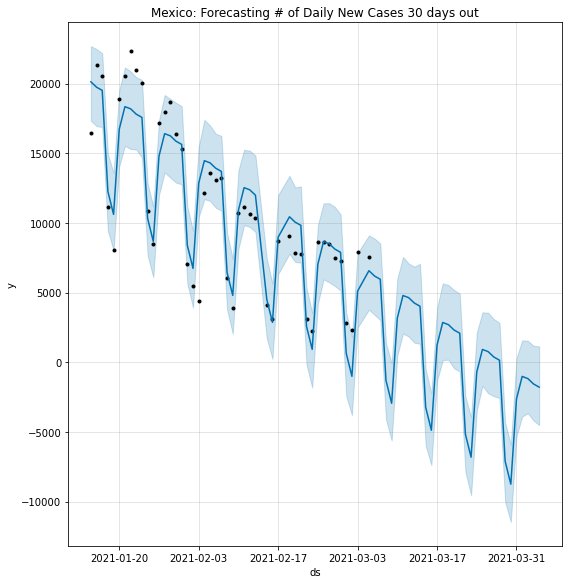

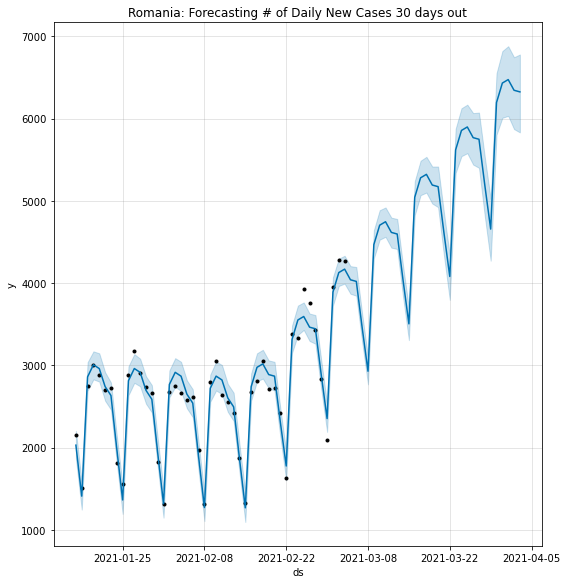

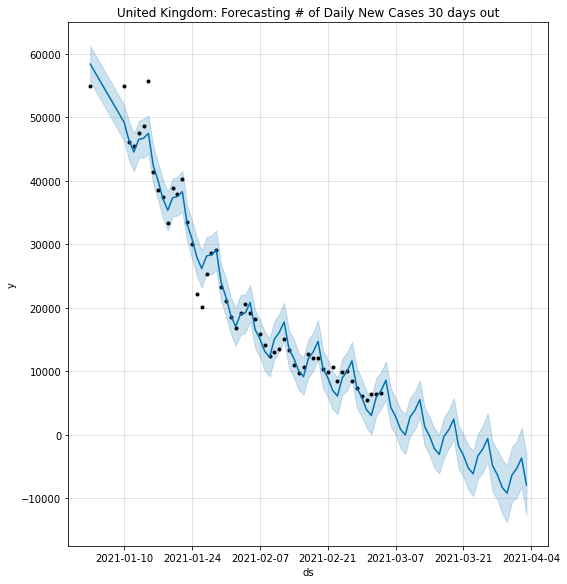

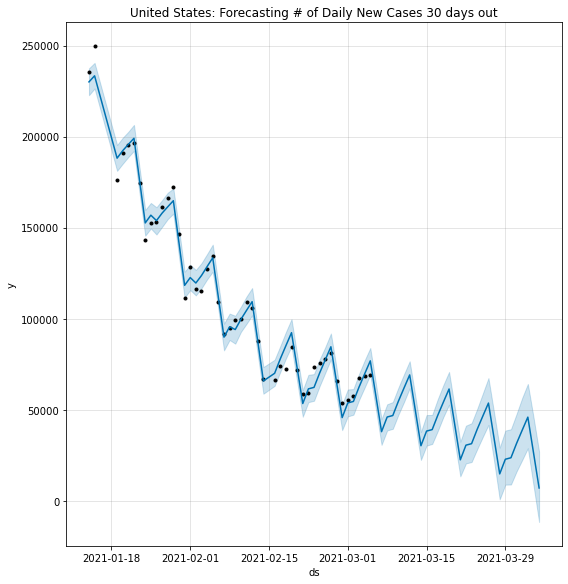

In [35]:
for country in countries:
    country_df=final_df.loc[final_df['country']==country].rename(columns={'date':'ds','daily_new_cases':'y'})
    fb_model=Prophet()
    fb_model.fit(country_df)
    fb_data_future=fb_model.make_future_dataframe(periods=30)
    fb_forecast=fb_model.predict(fb_data_future)
    #fb_forecast[['trend','yhat']].plot()
    fig,ax=plt.subplots(figsize=(8,8))
    fig_fb=fb_model.plot(fb_forecast,ax=ax)
    ax.set_title(f"{country}: Forecasting # of Daily New Cases 30 days out")
    plt.savefig(f"./CovidApp/static/images/{country}-daily-new.png");

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

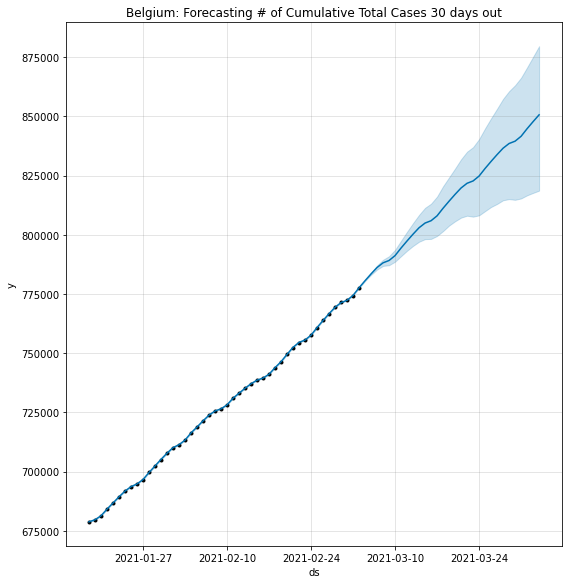

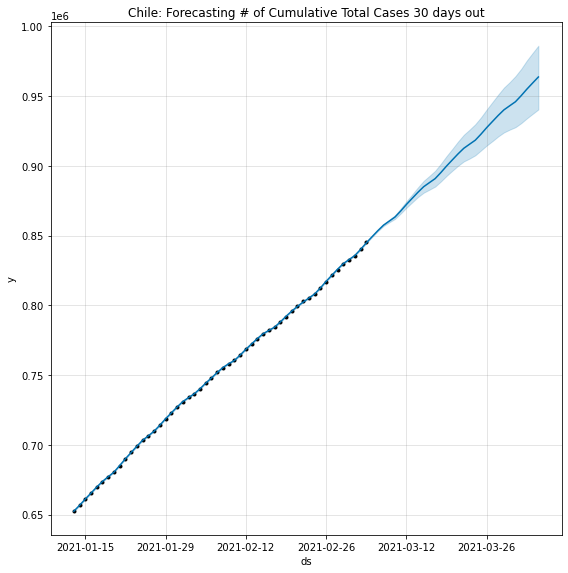

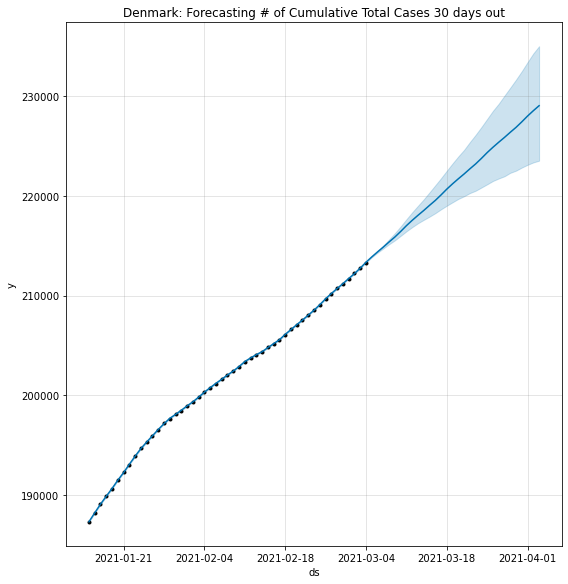

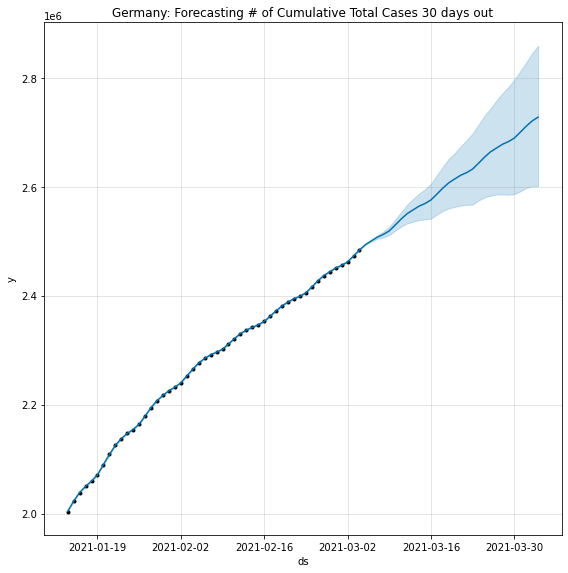

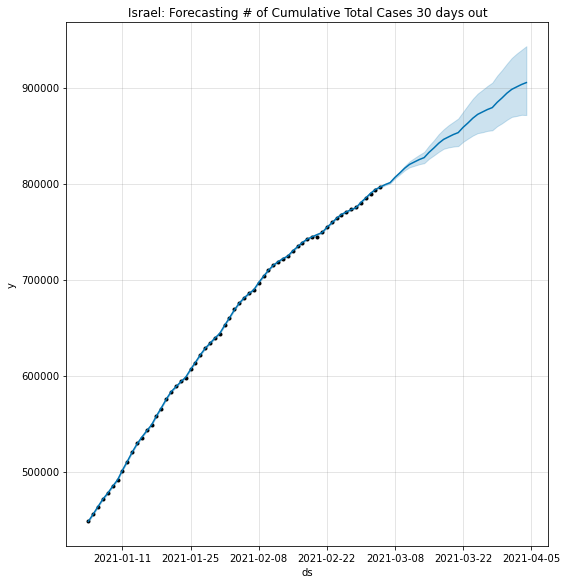

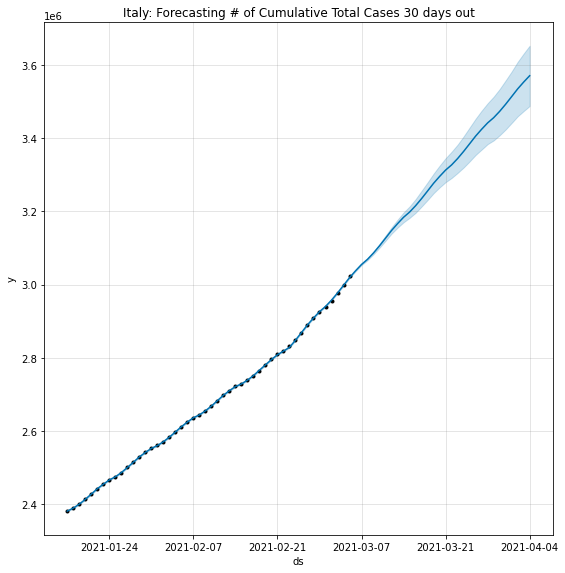

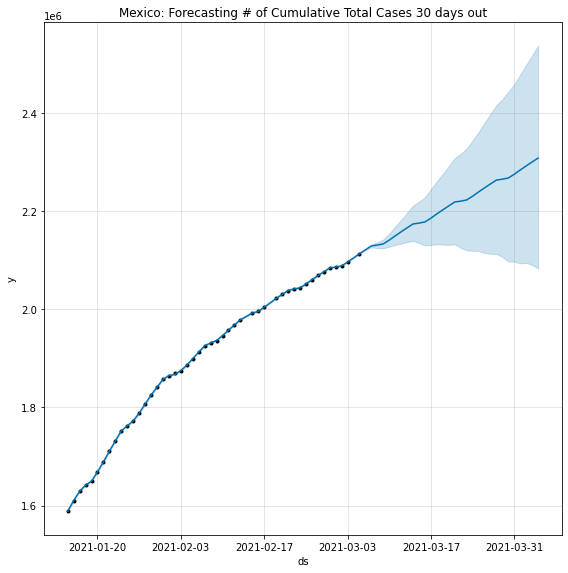

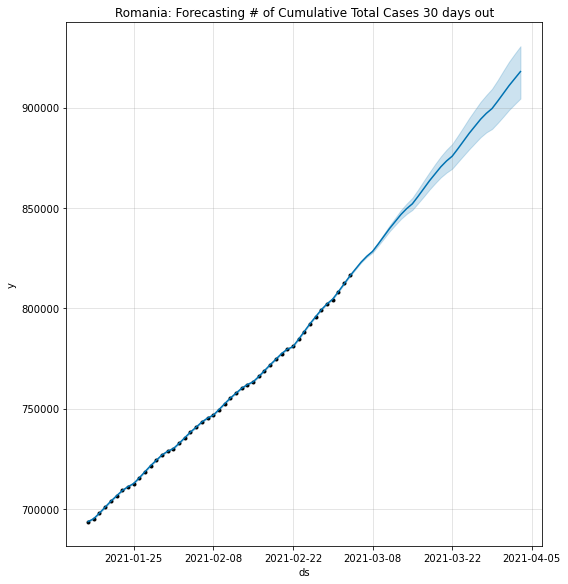

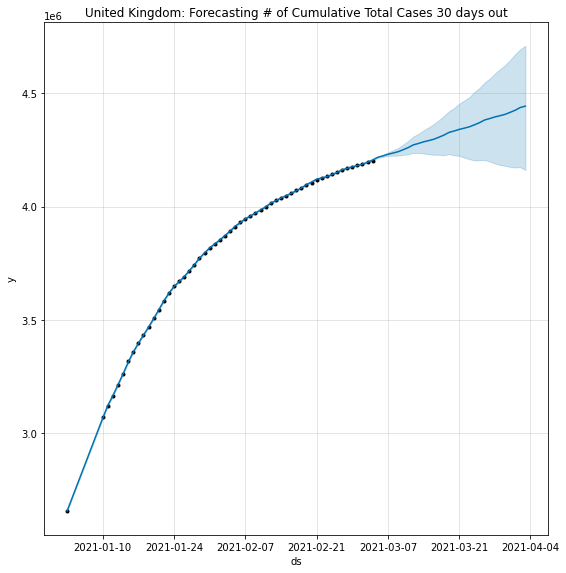

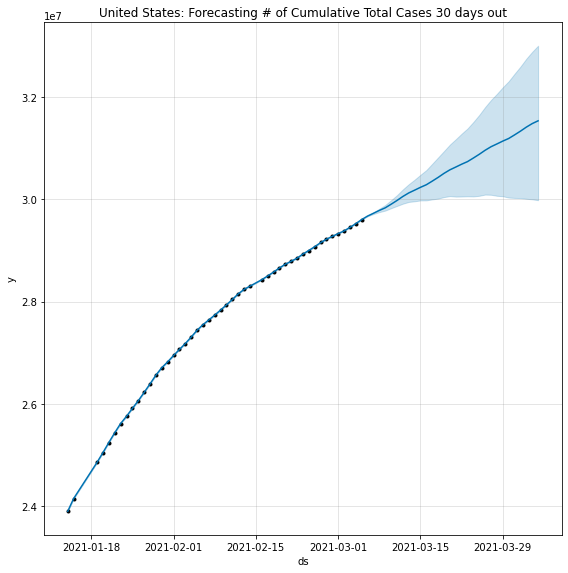

In [36]:
for country in countries:
    country_df=final_df.loc[final_df['country']==country].rename(columns={'date':'ds','cumulative_total_cases':'y'})
    fb_model=Prophet()
    fb_model.fit(country_df)
    fb_data_future=fb_model.make_future_dataframe(periods=30)
    fb_forecast=fb_model.predict(fb_data_future)
    #fb_forecast[['trend','yhat']].plot()
    fig,ax=plt.subplots(figsize=(8,8))
    fig_fb=fb_model.plot(fb_forecast,ax=ax)
    ax.set_title(f"{country}: Forecasting # of Cumulative Total Cases 30 days out")
    plt.savefig(f"./CovidApp/static/images/{country}-total-cases.png");

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

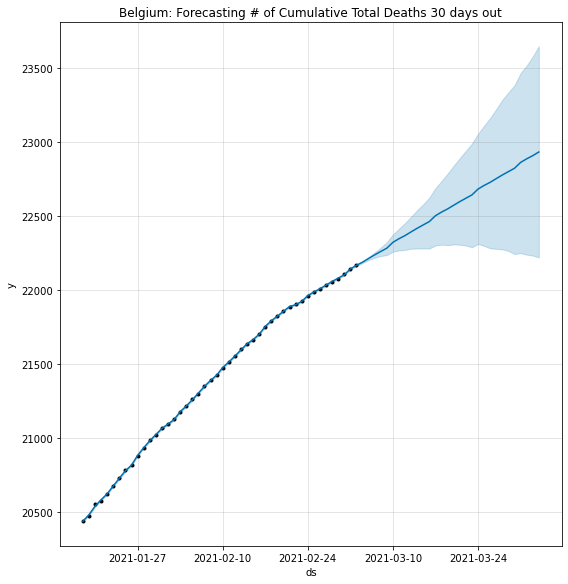

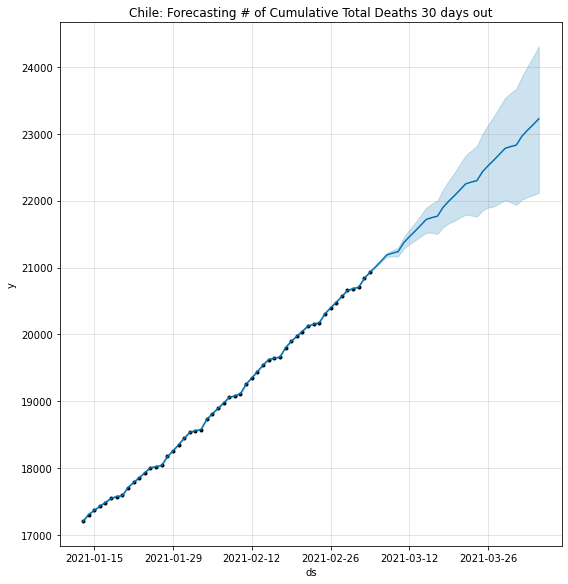

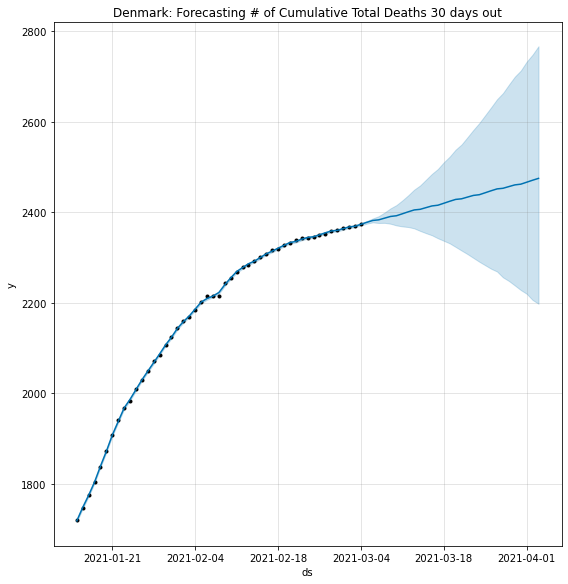

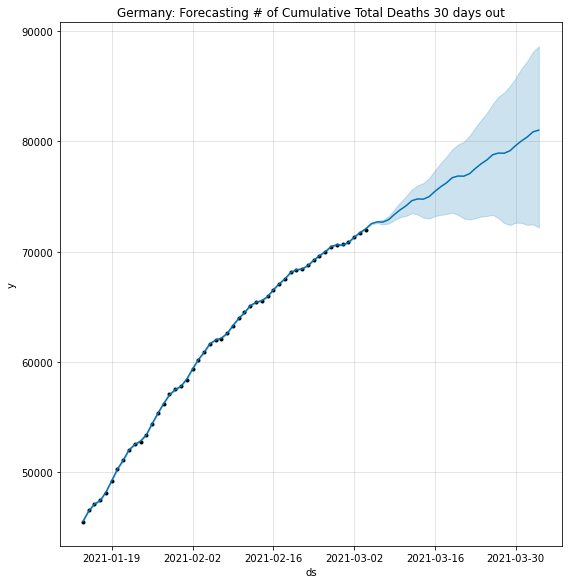

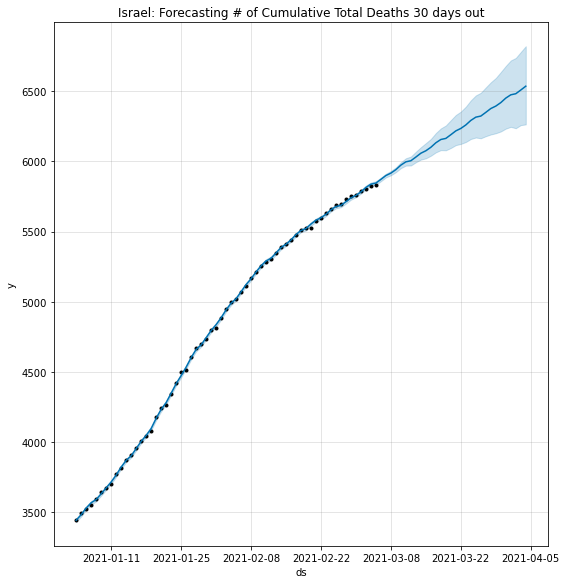

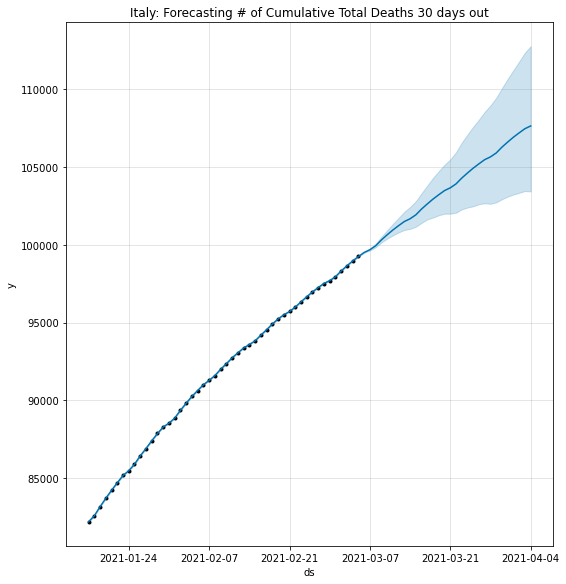

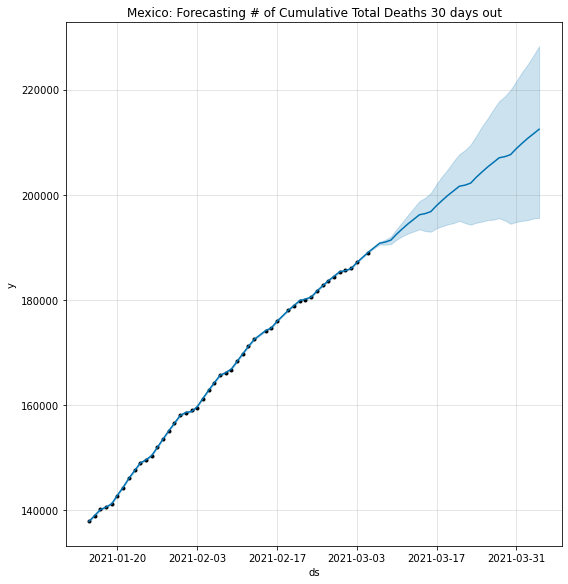

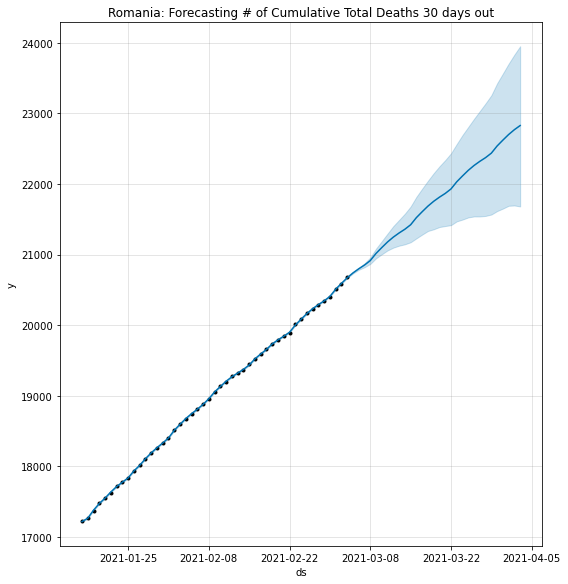

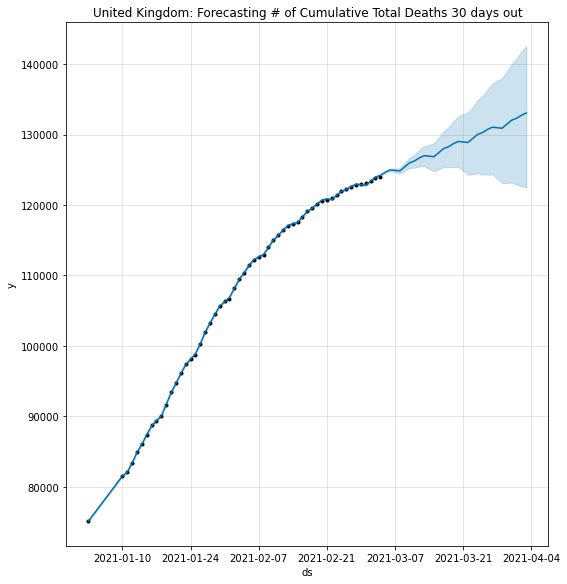

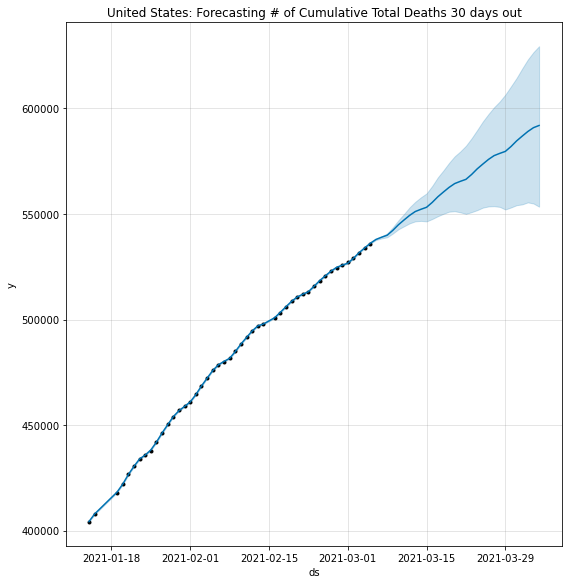

In [37]:
for country in countries:
    country_df=final_df.loc[final_df['country']==country].rename(columns={'date':'ds','cumulative_total_deaths':'y'})
    fb_model=Prophet()
    fb_model.fit(country_df)
    fb_data_future=fb_model.make_future_dataframe(periods=30)
    fb_forecast=fb_model.predict(fb_data_future)
    #fb_forecast[['trend','yhat']].plot()
    fig,ax=plt.subplots(figsize=(8,8))
    fig_fb=fb_model.plot(fb_forecast,ax=ax)
    ax.set_title(f"{country}: Forecasting # of Cumulative Total Deaths 30 days out")
    plt.savefig(f"./CovidApp/static/images/{country}-total-deaths.png");

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

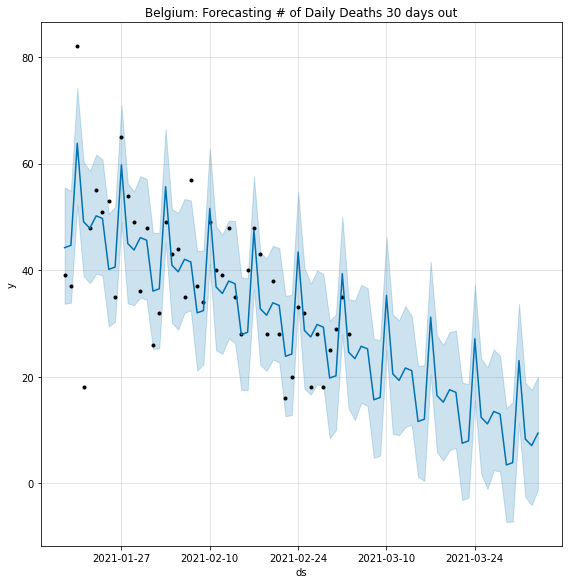

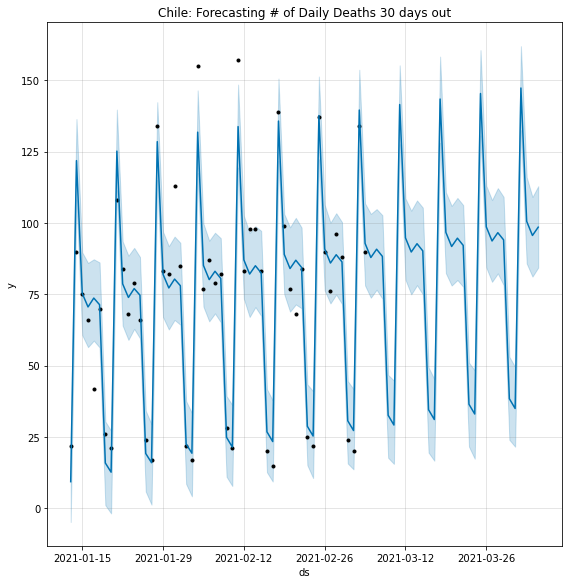

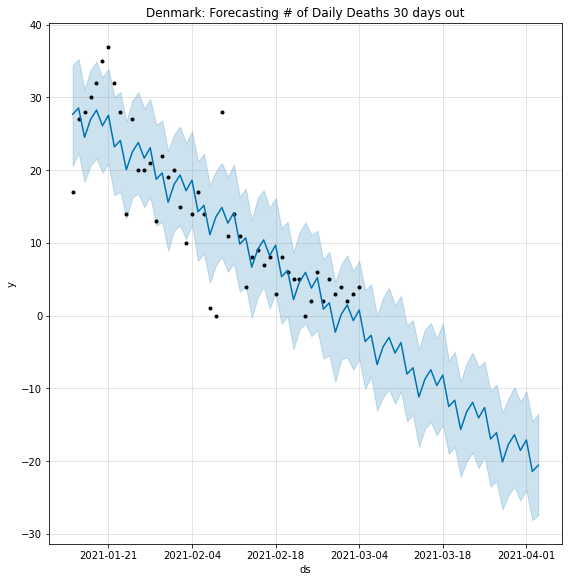

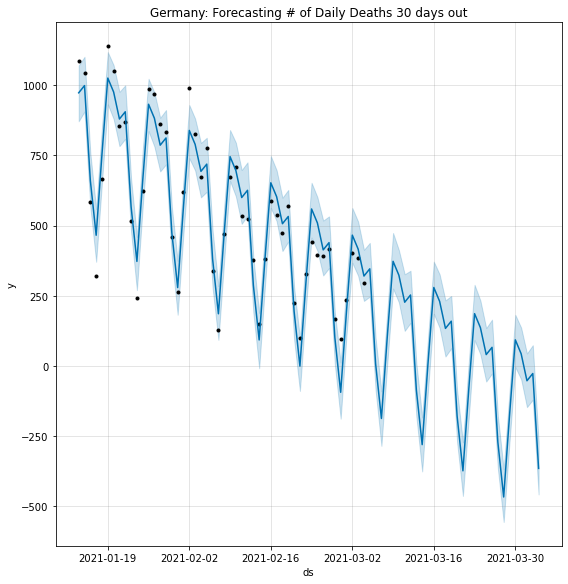

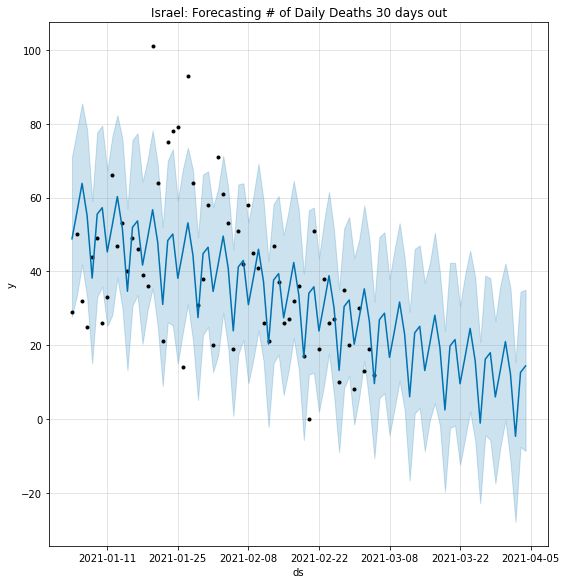

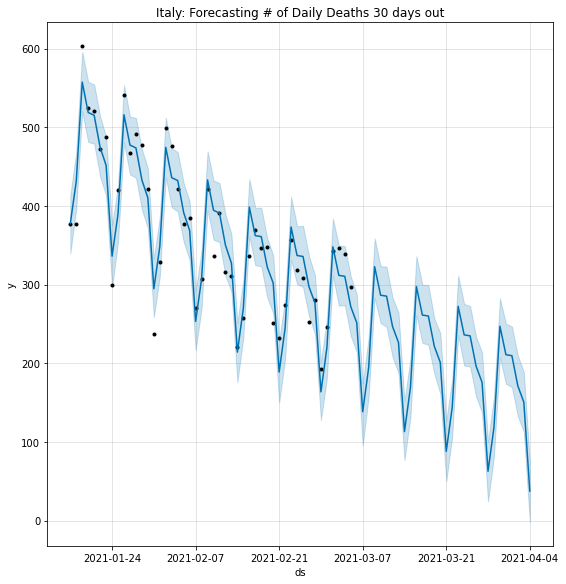

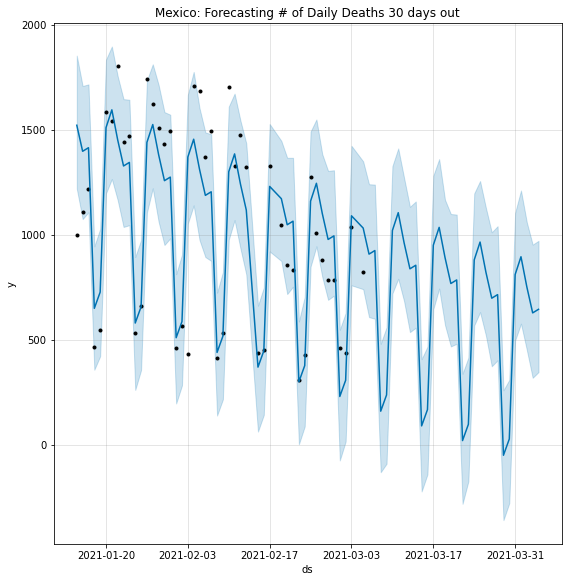

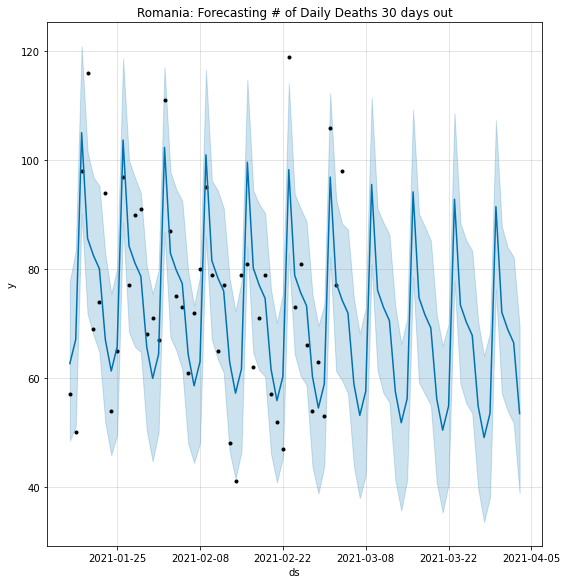

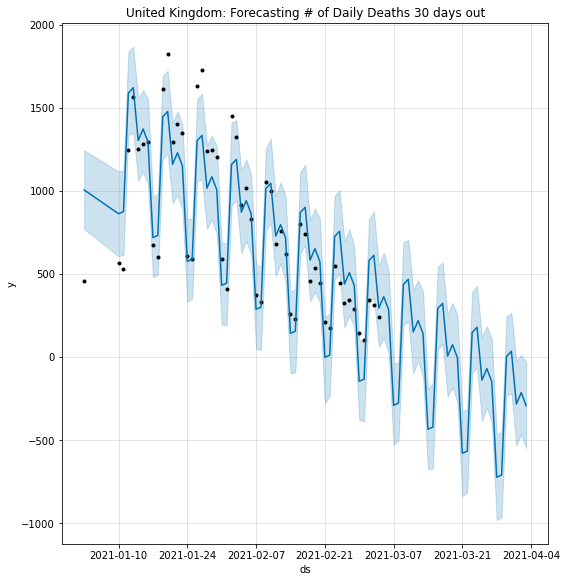

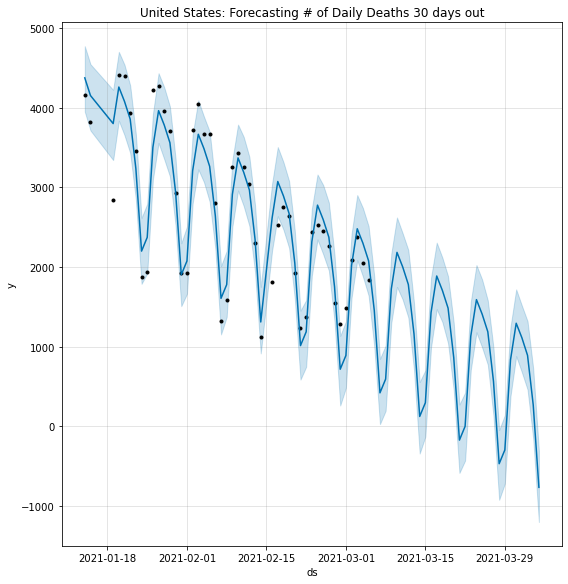

In [38]:
for country in countries:
    country_df=final_df.loc[final_df['country']==country].rename(columns={'date':'ds','daily_new_deaths':'y'})
    fb_model=Prophet()
    fb_model.fit(country_df)
    fb_data_future=fb_model.make_future_dataframe(periods=30)
    fb_forecast=fb_model.predict(fb_data_future)
    #fb_forecast[['trend','yhat']].plot()
    fig,ax=plt.subplots(figsize=(8,8))
    fig_fb=fb_model.plot(fb_forecast,ax=ax)
    ax.set_title(f"{country}: Forecasting # of Daily Deaths 30 days out")
    plt.savefig(f"./CovidApp/static/images/{country}-daily-deaths.png");

###     5.4. Correlation Matrix
####     A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.


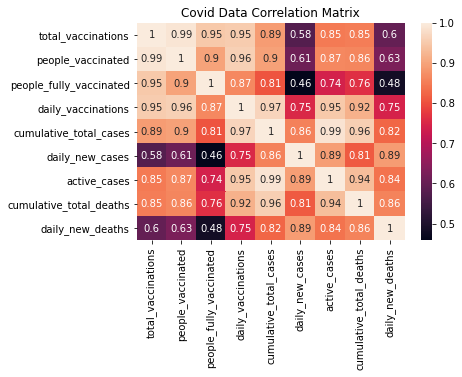

In [39]:
corrMatrix = final_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title(f"Covid Data Correlation Matrix")
plt.savefig("./CovidApp/static/images/correlation-matrix.png")
plt.show();
